In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pymultinest as pmn
import glob
import sys
import os
import corner

# from scipy.integrate import quad
from astropy.cosmology import wCDM, FlatwCDM
# from astropy.cosmology import w0waCDM, Flatw0waCDM

In [3]:
# !which python 

In [26]:
# Flatw0waCDM(70, 0.3)

In [27]:
### Generate mu's by hand

# je = wwcdm.distmod(z=np.arange(0.01,.1,.003))
# je = wwcdm.distmod(z=np.linspace(0.01,1.3,31))
wwcdm = wCDM(H0=70., Om0=0.3, Ode0=.7, w0= -1.)
je = wwcdm.distmod((jla_bins[:,0]))
print (len(je))

l = np.sort(je)
print (l)

np.savetxt('by_hand.txt', l)
j = np.loadtxt('by_hand.txt', usecols = 0)

31
[33.17531838 33.57453613 33.91257186 34.20582368 34.58391177 35.00530935
 35.27640666 35.66641731 36.06022277 36.3960782  36.77915423 37.14602528
 37.49606585 37.85772565 38.24468549 38.619915   38.99907248 39.38960476
 39.78077269 40.16596422 40.57038455 40.97210759 41.37999371 41.79747283
 42.21389327 42.64065537 43.06604644 43.49922938 43.93421349 44.36841052
 44.80507182] mag


In [1]:
#define all the data here (currently SN only)
data_path = '../jla_data/'
jla_bins = np.loadtxt(data_path + 'dist_binned.txt')
cov_mat = np.loadtxt(data_path + 'covmat_binned.txt')

vs = np.vstack([sorted(jla_bins[:, 0]), sorted(jla_bins[:, 1])]).T # Transpose jla summary data
vv = np.vstack([sorted(jla_bins[:, 0]), (j)]).T # Transpose using the by-hand array

np.savetxt('../jla_data/dist_binned_A.txt', vs) # Save the transpose matrix
jla_bins_a = np.loadtxt('../jla_data/dist_binned_A.txt') # Load the tranpose matrix
np.savetxt('../jla_data/dist_binned_B.txt', vv) # Save the transpose matrix using the by-hand array
jla_bins_b = np.loadtxt('../jla_data/dist_binned_B.txt')# Load the transpose by-hand matrix

cov_mat *= 1e-6
Cinv = np.linalg.inv(cov_mat)

NameError: name 'np' is not defined

In [30]:
print (jla_bins_b[:,1])

[33.17531838 33.57453613 33.91257186 34.20582368 34.58391177 35.00530935
 35.27640666 35.66641731 36.06022277 36.3960782  36.77915423 37.14602528
 37.49606585 37.85772565 38.24468549 38.619915   38.99907248 39.38960476
 39.78077269 40.16596422 40.57038455 40.97210759 41.37999371 41.79747283
 42.21389327 42.64065537 43.06604644 43.49922938 43.93421349 44.36841052
 44.80507182]


In [21]:
#define the likelihood and the prior in this cell
#currently only for wCDM


def llhood(model_param, ndim, npar):
    """
    This is the function where we define the log likelihood 
    log(Lhood) = -0.5*chisquare
    
    Parameters
    ----------
    model_param : sequence
        sequence of model parameters (Om, w, H0, M)
        in a wCDM    
    ndim : integer
         length of model_params
    npar : integer
        The number of parameters 
    """
    
    ### Calculate mu using priors and z from jla
    om, w, h0, M = [model_param[i] for i in range(4)]
#     wc = wCDM(h0, om, 1-om, w0=w)  
    wc = FlatwCDM(h0, om, w0=w)
    dl_mpc = wc.luminosity_distance(jla_bins[:,0]).value # Using jla data
    mu_th = 5*np.log10(dl_mpc) + 25.
    
    ### Calulate chi2 using (mu_th) - (mu_some_input_such_as_jla) 
#     dif_arr = mu_th - jla_bins_a[:,1] + M # Using jla data
    dif_arr = mu_th - jla_bins_b[:,1] + M # Using by-hand data
    chisq = np.dot(dif_arr.T, np.dot(Cinv, dif_arr))
    return -0.5*chisq

def prior(cube, ndim, npar):
    """
    Define the prior for each parameter
    i.e. before doing the experiment what do we know about these parameters
    """
    cube[0]  = cube[0]*1
    cube[1]  = cube[1]*4. - 2.
    cube[2]  = cube[2]*50. + 50.
#     cube[3]  = cube[3]*4. - 2.  
    cube[3]  = cube[3]*0.00000000000001

In [22]:
#prefix for filenames
prefix = 'jla_Flatwcdm-2'
chain_dir = '/Users/markpoe/ZTF/lowzSN/notebooks/chains/' + prefix + '/'

if not os.path.exists(chain_dir):
    os.makedirs(chain_dir)

In [31]:
### Remember to reset live points in run.py to n_live_points = 400; when using this script

In [23]:
#running the nested sampling algorithm
#the verbose argument is to see how the sampler is progressing 
pmn.run(llhood, prior, 4, verbose=True, outputfiles_basename=chain_dir)

/Users/markpoe/ZTF/lowzSN/notebooks/chains/jla_Flatwcdm-2/


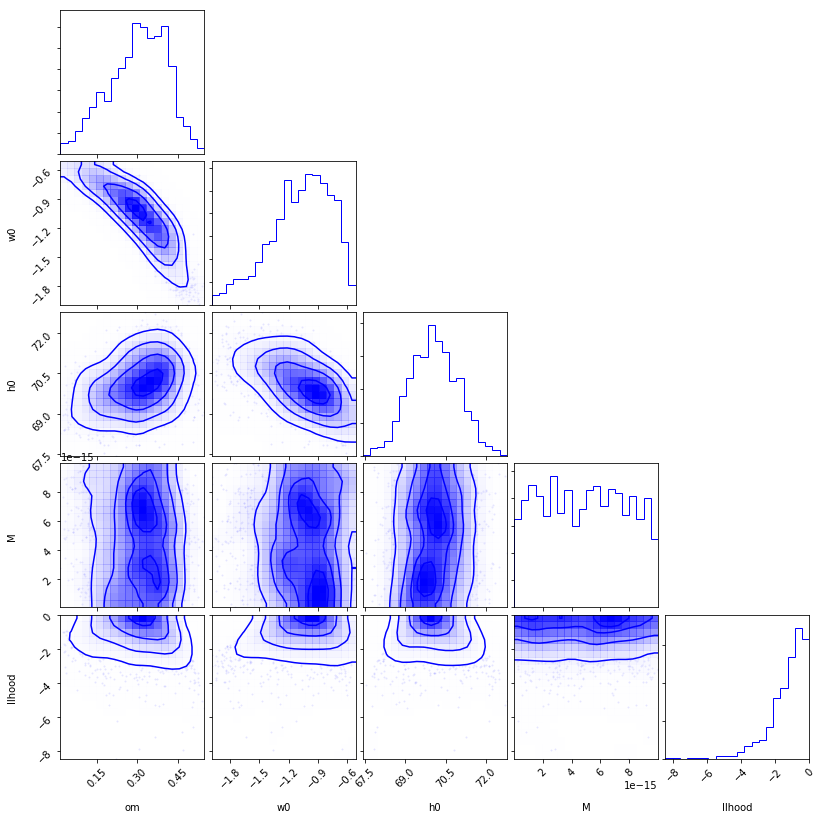

In [24]:
#a quick plotting function
data = np.loadtxt(chain_dir+'post_equal_weights.dat')
print (chain_dir)
figure = corner.corner(data, smooth=1.5, plot_contours=True, labels=['om', 'w0', 'h0', 'M', 'llhood'], color='b')
# figure.savefig("test.png")

In [184]:
# class pymultinest.analyse.Analyzer

# create analyzer object
a = pmn.analyse.Analyzer(4, outputfiles_basename = chain_dir+prefix)

# get a dictionary containing information about
#   the logZ and its errors
#   the individual modes and their parameters
#   quantiles of the parameter posteriors
stats = a.get_stats()

# get the best fit (highest likelihood) point
bestfit_params = a.get_best_fit()

# iterate through the "posterior chain"
# for params in a.get_equal_weighted_posterior():
#         print (params)

print (bestfit_params)

data_a = a.get_data()
print (data_a)


  analysing data from /Users/markpoe/ZTF/lowzSN/notebooks/chains/jla_wcdm-m_zero.txt
{'log_likelihood': -13.369410361606661, 'parameters': [0.23060258596184913, -0.8846281733626629, 75.69136663740935, 0.16661109049594458]}
[[ 8.78772072e-99  4.78075120e+02  1.33264363e-01 -2.14637041e-01
   9.14641678e+01  1.04649472e+00]
 [ 9.18748718e-99  4.77981146e+02  4.95154858e-02 -1.51110649e+00
   8.99387747e+01  3.77653122e-01]
 [ 9.35037925e-99  4.77940997e+02  5.82380235e-01 -1.85930848e+00
   8.17389101e+01  6.92536831e-01]
 ...
 [ 6.78834232e-04  2.73152474e+01  1.19684788e-01 -6.85955696e-01
   9.67365888e+01  7.20431949e-01]
 [ 7.29340266e-04  2.71717206e+01  1.21398356e-01 -7.12305312e-01
   9.72522056e+01  7.22721450e-01]
 [ 8.51424885e-04  2.68621788e+01  1.77288830e-01 -7.69687266e-01
   9.59381737e+01  6.92018091e-01]]


In [2]:
om = .3

In [3]:
((om - 0.3)**2./(1e-15)**2.)

0.0